In [1]:
import sys
try:
    if path:
        raise Exception('changed')
except:
    path = True
    sys.path.append('../')


import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from src.bos_model_polynomials import compute_polynomials
from src.compute_u import compute_u as compute_polynomials_god
from src.check_log_concavity_bos import *
from src.god_model_estimator import probability_x_given_mu_pi

In [2]:
from pickle import load, dump

In [3]:
with open('../GOD_coefficients.pkl', 'rb') as f:
    god_coefs = load(f)

In [4]:
def compute_derivative_polynomials(p: np.ndarray) -> np.ndarray:
    """
    Compute the derivative of the polynomials represented by the coefficients in p.

    P(x) = p[0] * x^(n-1) + p[1] * x^(n-2) + ... + p[n-1]

    Parameters
    ----------
    p : np.ndarray
        Coefficients of the polynomial.
    
    Returns
    -------
    np.ndarray
        Coefficients of the derivative of the polynomial.
    """
    n = len(p)
    dp = np.zeros(n-1)
    for i in range(n-1):
        dp[i] = p[i] * (n-1-i)
    return dp

In [5]:
def expand_polynomial(c: np.ndarray) -> np.polynomial.Polynomial:
    """
    Expand the polynomial represented by the coefficients in c.

    P(x) = sum_{i=0}^{n - 1} c[i] * x^{n - 1 - i} * (1 - x)^i

    Parameters
    ----------
    c : np.ndarray
        Coefficients of the polynomial.
    
    Returns
    -------
    np.polynomial.Polynomial
        The expanded polynomial.
    """
    n = len(c)
    # p = np.zeros(2 * n - 1)
    # for i in range(n):
    #     for j in range(i+1):
    #         p[n-1-i+j] += c[i] * (-1)**j * np.math.comb(i, j)
    # copilot =  np.polynomial.Polynomial(p[::-1])

    p = np.polynomial.Polynomial(0)
    x = np.polynomial.Polynomial([0, 1])
    xb = 1 - x
    for i in range(n):
        p += c[i] * x ** (n - 1 - i) * xb ** i

    # assert p == copilot, f'{str(p)} != {str(copilot)}'

    return p


In [43]:
eps = 1e-5
pis = np.linspace(eps, 1 - eps, 1_000)
for M in tqdm(range(1, 26 + 1)):
    for x in range(M):
        for mu in range(M):
            p = expand_polynomial(god_coefs[M][mu, x])
            ppis = p(pis)
            other = np.array([probability_x_given_mu_pi(M, x + 1, mu + 1, pi, god_coefs[M]) for pi in pis])
            assert np.all(np.abs(ppis - other) < 1e-5), \
                f"Error for {M=} {x=} {mu=} {np.abs(ppis - other).max()}"
            

  0%|          | 0/26 [00:00<?, ?it/s]

In [42]:
pis = np.linspace(0, 1, 10)
p = expand_polynomial(god_coefs[M][mu, x])
ppis = p(pis)
other = np.array([probability_x_given_mu_pi(M, x, mu, pi, god_coefs[M]) for pi in pis])
np.abs(ppis - other), ppis, other

/media/Data/Data/M2/Cours/Probabilistic graphical models/Projet/Ordinal-data-clustering/notebooks/../src/god_model_estimator.py:466: RuntimeWarning: divide by zero encountered in scalar divide
  return pi ** (m - 1) * evaluate_polynomial(u[mu - 1, x - 1], (1 - pi) / pi)


(array([       nan, 0.34567901, 0.21604938, 0.11111111, 0.0308642 ,
        0.02469136, 0.05555556, 0.0617284 , 0.04320988, 0.        ]),
 array([0.5       , 0.49382716, 0.47530864, 0.44444444, 0.40123457,
        0.34567901, 0.27777778, 0.19753086, 0.10493827, 0.        ]),
 array([       nan, 0.83950617, 0.69135802, 0.55555556, 0.43209877,
        0.32098765, 0.22222222, 0.13580247, 0.0617284 , 0.        ]))

In [39]:
pis

array([1.00000000e-05, 1.11118889e-01, 2.22227778e-01, 3.33336667e-01,
       4.44445556e-01, 5.55554444e-01, 6.66663333e-01, 7.77772222e-01,
       8.88881111e-01, 9.99990000e-01])

In [40]:
god_coefs[M][mu, x]

array([0. , 1. , 0.5])

In [41]:
p

Polynomial([ 0.5,  0. , -0.5], domain=[-1.,  1.], window=[-1.,  1.], symbol='x')

In [17]:
probability_x_given_mu_pi(6, 3, 0, 0.5, god_coefs[6])

0.11979166666666666

In [18]:

p = expand_polynomial(god_coefs[6][0, 3])
p(0.5)

0.11979166666666666

0.0 + 0.5·x - 0.16666667·x² - 1.0·x³ + 0.5·x⁴ + 0.16666667·x⁵
0.5 - 0.33333333·x - 3.0·x² + 2.0·x³ + 0.83333333·x⁴
True
0.0 + 0.25·x - 0.25·x² - 1.94444444·x³ + 2.08333333·x⁴ + 3.0·x⁵ -
3.69444444·x⁶ - 0.33333333·x⁷ + 0.75·x⁸ + 0.13888889·x⁹


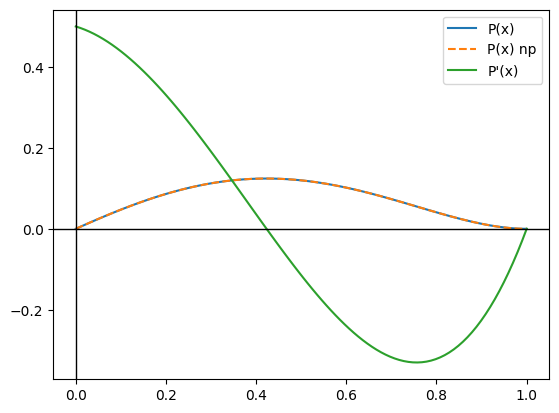

In [14]:
# check the function by plotting the polynomials and their derivatives

p = god_coefs[6][0, 3]
p = expand_polynomial(god_coefs[6][0, 3]).coef[::-1]
pnp = np.polynomial.Polynomial(p[::-1])
print(pnp)
dp = compute_derivative_polynomials(p)
dpnp = pnp.deriv()
print(dpnp)
print(np.polynomial.Polynomial(dp[::-1]) == dpnp)
x = np.linspace(0, 1, 100)

print(pnp * dpnp)

plt.plot(x, np.polyval(p, x), label='P(x)')
plt.plot(x, pnp(x), label='P(x) np', linestyle='--')
plt.plot(x, np.polyval(dp, x), label="P'(x)")
# plot the 0 lines
plt.axhline(0, color='black', lw=1)
plt.axvline(0, color='black', lw=1)
plt.legend()

P(x) = 1.0 - 3.0·x + 5.33333333·x² - 6.5·x³ + 4.0·x⁴ - 0.83333333·x⁵
P'(x) = -3.0 + 10.66666667·x - 19.5·x² + 16.0·x³ - 4.16666667·x⁴
(log P)''(x) ~ (P''P - P'^2)(x) = 1.66666667 - 7.0·x - 8.88888889·x² + 74.0·x³ - 144.41666667·x⁴ +
147.11111111·x⁵ - 85.66666667·x⁶ + 26.66666667·x⁷ - 3.47222222·x⁸


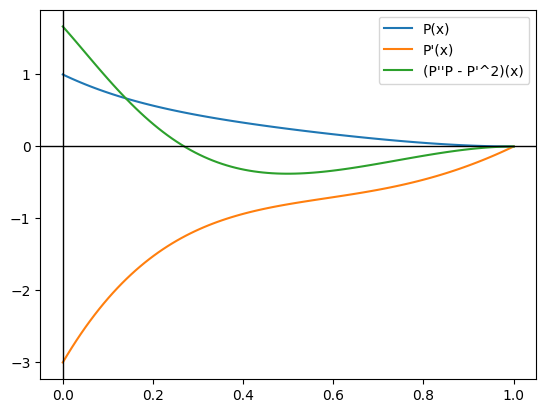

In [55]:
# check the function by plotting the polynomials and their derivatives

p = expand_polynomial(god_coefs[6][2, 5]).coef[::-1]
p = np.polynomial.Polynomial(p[::-1])

x = np.linspace(0, 1, 100)

dp = p.deriv()
dlog = get_second_log_derivative_numerator(p.coef[::-1])

print(f"P(x) = {str(p)}")
print(f"P'(x) = {str(dp)}")
print(f"(log P)''(x) ~ (P''P - P'^2)(x) = {str(dlog)}")

plt.plot(x, p(x), label="P(x)")
plt.plot(x, dp(x), label="P'(x)")
plt.plot(x, dlog(x), label="(P''P - P'^2)(x)") 

# plot the 0 lines
plt.axhline(0, color='black', lw=1)
plt.axvline(0, color='black', lw=1)
plt.legend()

P(x) = 0.0 + 0.0·x + 16.08333333·x² - 110.83333333·x³ + 338.58333333·x⁴ -
202.55·x⁵ - 2931.68214286·x⁶ + 15226.64761905·x⁷ - 43068.2234127·x⁸ +
82999.43849207·x⁹ - 115375.08769842·x¹⁰ + 117308.11230159·x¹¹ -
86610.60436508·x¹² + 45245.00277778·x¹³ - 15862.59365079·x¹⁴ +
3349.98849206·x¹⁵ - 322.28174603·x¹⁶
P'(x) = 0.0 + 32.16666667·x - 332.5·x² + 1354.33333333·x³ - 1012.75·x⁴ -
17590.09285714·x⁵ + 106586.53333333·x⁶ - 344545.78730159·x⁷ +
746994.94642859·x⁸ - 1153750.87698415·x⁹ + 1290389.2353175·x¹⁰ -
1039327.25238099·x¹¹ + 588185.03611113·x¹² - 222076.31111112·x¹³ +
50249.82738095·x¹⁴ - 5156.50793651·x¹⁵
(log P)''(x) ~ (P''P - P'^2)(x) = 0.0 + 0.0·x - 517.34722222·x² + 7130.27777778·x³ - 47743.18055556·x⁴ +
218642.55833333·x⁵ - 925561.63015873·x⁶ + 4466964.42063495·x⁷ -
22384836.32969606·x⁸ + (1.01304916e+08)·x⁹ - (4.0249457e+08)·x¹⁰ +
(1.42665171e+09)·x¹¹ - (4.54849123e+09)·x¹² + (1.29357685e+10)·x¹³ -
(3.23413108e+10)·x¹⁴ + (7.02299762e+10)·x¹⁵ - (1.31477788e+11)·x¹⁶ +
(2.11319936e

/tmp/ipykernel_9587/1328162964.py:25: RuntimeWarning: invalid value encountered in log
  plt.plot(xs, np.log(p(xs)), label="log P(x)")


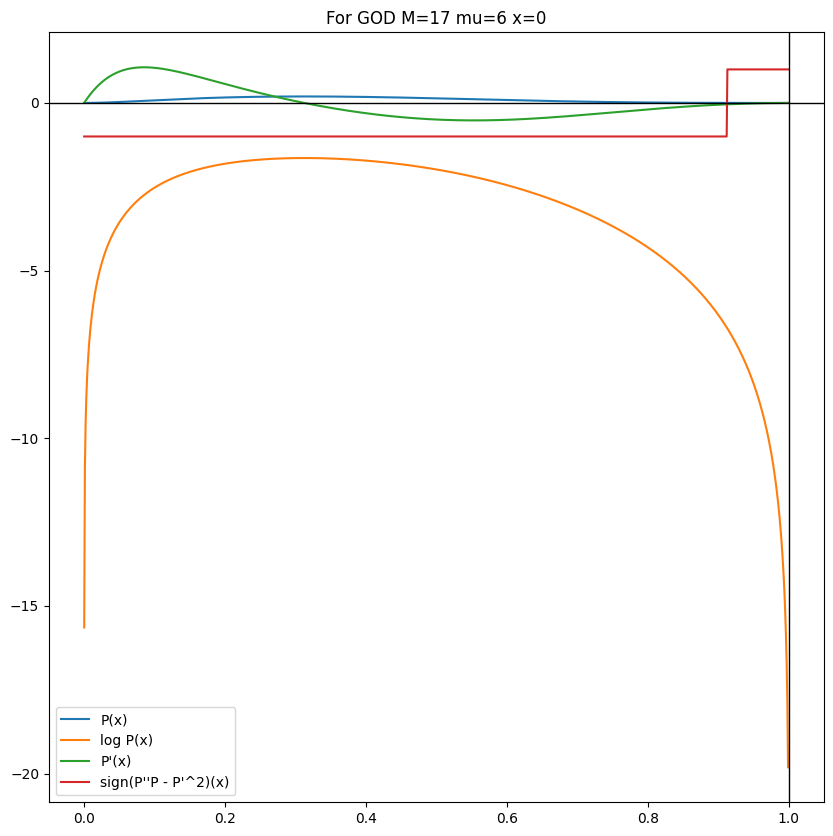

In [57]:
# check the function by plotting the polynomials and their derivatives

M = 17
mu = 6
x = 0

p = expand_polynomial(god_coefs[M][mu, x]).coef[::-1]
p = np.polynomial.Polynomial(p[::-1])

eps = 1e-4
xs = np.linspace(eps, 1 - eps, 1_000)
# xs = np.linspace(0.98, 1 - eps, 1_000)

dp = p.deriv()
dlog = get_second_log_derivative_numerator(p.coef[::-1])

print(f"P(x) = {str(p)}")
print(f"P'(x) = {str(dp)}")
print(f"(log P)''(x) ~ (P''P - P'^2)(x) = {str(dlog)}")

print(f"{np.min(p(xs))=}")

plt.figure(figsize=(10, 10))
plt.plot(xs, p(xs), label="P(x)")
plt.plot(xs, np.log(p(xs)), label="log P(x)")
plt.plot(xs, dp(xs), label="P'(x)")
# plt.plot(x, dlog(x) / p(x)**2, label="(P''P - P'^2)(x) / P^2(x)") 
# plt.plot(xs, dlog(xs), label="(P''P - P'^2)(x)") 
plt.plot(xs, np.sign(dlog(xs)), label="sign(P''P - P'^2)(x)") 

# plot the 0 lines
plt.axhline(0, color='black', lw=1)
# plt.axvline(0, color='black', lw=1)
plt.axvline(1, color='black', lw=1)

plt.title(f"For GOD {M=} {mu=} {x=}")
plt.legend()

In [7]:
god_coefs.keys()

dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26])

In [11]:
def check_negativity(p: np.polynomial.Polynomial) -> bool:
    """
    Check if the polynomial represented by the coefficients in p is negative (<= 0) for all x in [0, 1].

    Parameters
    ----------
    p : np.ndarray
        Coefficients of the polynomial.
    
    Returns
    -------
    bool
        True if the polynomial is positive for all x, False otherwise.
    """
    y = p(np.linspace(0, 1, 10_000))
    print(f"Max: {np.max(y)}")
    return np.all(y <= 0)

In [47]:
def check_unimodality(seq: np.ndarray) -> bool:
    """
    Check if the sequence is unimodal ie only negative values followed by only positive values.

    Parameters
    ----------
    seq : np.ndarray
        The sequence to check.
    
    Returns
    -------
    bool
        True if the sequence is unimodal, False otherwise.
    """
    seq = np.sign(seq)
    i = 0
    while i < len(seq) and seq[i] >= 0:
        i += 1
    return np.all(seq[i:] <= 0)

In [33]:
formal = 0
unformal = 0
max_step = 0
nb_steps = 0
eps = 0
xs = np.linspace(0.5, 1- eps, 1_000)
for M in tqdm(range(1, 26 + 1)):
    # u = compute_polynomials(M)
    for x in range(M):
        for mu in range(M):
            poly = expand_polynomial(god_coefs[M][x, mu])
            dpoly = poly.deriv()
            min_poly = np.min(poly(xs))
            if min_poly < -1e-6:
                print(f"Error for {M=} {x=} {mu=} {min_poly=}")
            assert min_poly >= -1e-5, f"Error for {M=} {x=} {mu=} {min_poly=}"

  0%|          | 0/26 [00:00<?, ?it/s]

Error for M=25 x=6 mu=24 min_poly=-1.3760083561464853e-06
Error for M=25 x=15 mu=0 min_poly=-1.4351016941471784e-06
Error for M=26 x=4 mu=25 min_poly=-2.4555266353587513e-06
Error for M=26 x=6 mu=24 min_poly=-1.3760083561464853e-06
Error for M=26 x=6 mu=25 min_poly=-1.3262225366794667e-06
Error for M=26 x=7 mu=0 min_poly=-1.0957153614988707e-06
Error for M=26 x=11 mu=0 min_poly=-1.4747245411945927e-06
Error for M=26 x=13 mu=0 min_poly=-1.1287859460473726e-06
Error for M=26 x=15 mu=25 min_poly=-2.1987057559254174e-06
Error for M=26 x=16 mu=1 min_poly=-1.4343834250309886e-06
Error for M=26 x=18 mu=0 min_poly=-1.7897251609610976e-06
Error for M=26 x=20 mu=0 min_poly=-1.4090603295269233e-06
Error for M=26 x=21 mu=0 min_poly=-4.714875728950574e-06
Error for M=26 x=24 mu=0 min_poly=-1.2111478580045798e-06
Error for M=26 x=25 mu=0 min_poly=-3.440178886648937e-06


In [50]:
formal = 0
unformal = 0
max_step = 0
nb_steps = 0
eps = 1e-3
xs = np.linspace(0.5, 1- eps, 1_000)
for M in tqdm(range(1, 26 + 1)):
    # u = compute_polynomials(M)
    for x in range(M):
        for mu in range(M):
            poly = expand_polynomial(god_coefs[M][x, mu])
            dpoly = poly.deriv()
            min_poly = np.min(poly(xs))
            dpoly_vals = dpoly(xs)
            if not check_unimodality(dpoly_vals):
                print(f"Error for {M=} {x=} {mu=}")
                raise Exception('changed')

  0%|          | 0/26 [00:00<?, ?it/s]

Error for M=12 x=0 mu=11


Exception: changed

In [51]:
np.sign(dpoly_vals)

array([-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1

In [36]:
dp

Polynomial([-1.50000000e+00, -1.33333333e+00, -1.25000000e+00, -2.21200000e+02,
        2.36383333e+03, -1.14175071e+04,  3.47857000e+04, -7.31752000e+04,
        1.08933300e+05, -1.14558500e+05,  8.31964833e+04, -3.96232000e+04,
        1.11025571e+04, -1.38218333e+03], domain=[-1.,  1.], window=[-1.,  1.], symbol='x')

In [59]:
formal = 0
unformal = 0
max_step = 0
nb_steps = 0
eps = 1e-10
xs = np.linspace(0.5, 1 - eps, 1_000)
for M in tqdm(range(1, 26 + 1)):
    # u = compute_polynomials(M)
    for x in range(M):
        for mu in range(M):
            poly_coefs = expand_polynomial(god_coefs[M][x, mu]).coef[::-1]
            original_poly = np.polynomial.Polynomial(poly_coefs[::-1])
            poly = get_second_log_derivative_numerator(poly_coefs)
            # assert poly.coef[1] < 0, f'Failed for {M=} {x=}, {mu=} dlog P :{str(poly)}'
            # print(f"Checking {M=} {x=}, {mu=}")
            if check_formal_negativity(poly):
                formal += 1
            else:
                unformal += 1
                max_val = np.max(poly(xs))
                # ok = check_negativity(poly)
                assert max_val < 1e-10, f'Failed for {M=} {x=}, {mu=} p: {str(poly)}'
                if max_val > 1e-3:
                    print(f"Warning for for {M=} {x=}, {mu=}, max={max_val}, p: {str(poly)}")
                    max_val_bis = np.max(poly(xs) / original_poly(xs) ** 2)
                    if max_val > 1e-5 and max_val_bis > 1e-5:
                        print(f"Warning for for {M=} {x=}, {mu=}, max={max_val}, p: {str(poly)}")
                        # assert max_val < 1e-5, f'Failed for {M=} {x=}, {mu=} p: {str(poly)}'
                # print(f'For {M=} {x=}, {mu=}', end=' ')
                # steps = check_fomralcaly_negativity(poly)
                # nb_steps += steps
                # max_step = max(max_step, steps)
                # assert steps, f'Failed for {M=} {x=}, {mu=} p: {str(poly)}'
                # print(f"For {M=} {x=}, {mu=}, {steps=}")
                    
                
            # assert check_log_concavity(u[x, mu]), f'Failed for {M=} {x=}, mu={mu}'
print(f'Formal: {formal}, Unformal: {unformal}, Max steps: {max_step}, Total steps: {nb_steps}')

  0%|          | 0/26 [00:00<?, ?it/s]

AssertionError: Failed for M=10 x=3, mu=0 p: 0.0 + 0.0·x - 256.88888889·x² + 2712.44444444·x³ - 14137.06111111·x⁴ +
48700.24444444·x⁵ - 124579.34888889·x⁶ + 248069.68888889·x⁷ -
388706.56805555·x⁸ + 476908.87777778·x⁹ - 453378.84444444·x¹⁰ +
329272.85333333·x¹¹ - 178956.84166667·x¹² + 70406.36666667·x¹³ -
18930.23333333·x¹⁴ + 3110.93333333·x¹⁵ - 235.6225·x¹⁶

[1.         2.5        0.83333333 0.         0.        ]
0.0 + 0.0·x + 0.83333333·x² + 0.83333333·x³ - 0.66666667·x⁴


For $x \in [0, 1]$

$\sum a_i x^i \leq 0 \iff \sum_{i=1}^n a_i x^i \leq -a_0$
 
$\iff \sum_{i=1}^n p_i x^i + \sum_{i=1}^n n_i x^i \leq -a_0$  (where $p_i$ and $n_i$ are the positive and negative parts of $a_i$)

$\Leftarrow \sum_{i=1}^n p_i x^i \leq -a_0$ 

$\Leftarrow \sum_{i=1}^n p_i \leq -a_0$

In [6]:
p = np.polynomial.Polynomial([1, -50, 100, 50])
print(p)
print(p.coef)

1.0 - 50.0·x + 100.0·x² + 50.0·x³
[  1. -50. 100.  50.]


In [46]:
formal = 0
unformal = 0
max_step = 0
nb_steps = 0
for M in tqdm(range(40, 1, -1)):
    u = compute_polynomials(M)
    for x in range(M):
        for mu in range(M):
            poly = get_second_log_derivative_numerator(u[x, mu])
            # assert poly.coef[1] < 0, f'Failed for {M=} {x=}, {mu=} dlog P :{str(poly)}'
            if check_formal_negativity(poly):
                formal += 1
            else:
                unformal += 1
                # print(f'For {M=} {x=}, {mu=}', end=' ')
                steps = check_fomralcaly_negativity(poly)
                nb_steps += steps
                max_step = max(max_step, steps)
                assert steps, f'Failed for {M=} {x=}, {mu=} p: {str(poly)}'
                print(f"For {M=} {x=}, {mu=}, {steps=}")
                    
                
            # assert check_log_concavity(u[x, mu]), f'Failed for {M=} {x=}, mu={mu}'
print(f'Formal: {formal}, Unformal: {unformal}, Max steps: {max_step}, Total steps: {nb_steps}')

  0%|          | 0/39 [00:00<?, ?it/s]

For M=40 x=0, mu=8, steps=3
For M=40 x=0, mu=9, steps=3
For M=40 x=0, mu=10, steps=4
For M=40 x=0, mu=11, steps=5
For M=40 x=0, mu=12, steps=5
For M=40 x=0, mu=13, steps=7
For M=40 x=0, mu=14, steps=9
For M=40 x=0, mu=15, steps=11
For M=40 x=0, mu=16, steps=14
For M=40 x=0, mu=17, steps=17
For M=40 x=0, mu=18, steps=22
For M=40 x=0, mu=19, steps=27
For M=40 x=0, mu=20, steps=34
For M=40 x=0, mu=21, steps=43
For M=40 x=0, mu=22, steps=54
For M=40 x=0, mu=23, steps=67
For M=40 x=0, mu=24, steps=85
For M=40 x=0, mu=25, steps=107
For M=40 x=0, mu=26, steps=136
For M=40 x=0, mu=27, steps=173
For M=40 x=0, mu=28, steps=223
For M=40 x=0, mu=29, steps=289
For M=40 x=0, mu=30, steps=381
For M=40 x=0, mu=31, steps=509
For M=40 x=0, mu=32, steps=692
For M=40 x=0, mu=33, steps=963
For M=40 x=0, mu=34, steps=1379
For M=40 x=0, mu=35, steps=2056
For M=40 x=0, mu=36, steps=3254
For M=40 x=0, mu=37, steps=5767
For M=40 x=0, mu=38, steps=13453
For M=40 x=0, mu=39, steps=62150
For M=40 x=1, mu=10, steps

In [ ]:
formal = 0
unformal = 0
max_unformal = -1
for M in tqdm(range(10, 1, -1)):
    u = compute_polynomials(M)
    for x in range(M):
        for mu in range(M):
            poly = get_second_log_derivative_numerator(u[x, mu])
            assert poly.coef[1] < 0, f'Failed for {M=} {x=}, {mu=} dlog P :{str(poly)}'
            if check_formal_negativity(poly):
                formal += 1
            else:
                unformal += 1
                maxi = np.max(poly(np.linspace(0, 1, 10_000)))
                max_unformal = max(max_unformal, maxi)
                if maxi > 0:
                    print(f'Failed for {M=} {x=}, {mu=}, {maxi=}')
                
            # assert check_log_concavity(u[x, mu]), f'Failed for {M=} {x=}, mu={mu}'
print(f'Formal: {formal}, Unformal: {unformal}, Max unformal: {max_unformal:.2e}')

  0%|          | 0/9 [00:00<?, ?it/s]

AssertionError: Failed for M=10 x=0, mu=2 dlog P :-0.03726424 + 0.00537873·x - 0.03473501·x² - 0.00958157·x³ +
0.00416474·x⁴ + 0.0017738·x⁵ - 0.00060223·x⁶ - 0.00031116·x⁷ -
(5.30876069e-05)·x⁸ - (4.7488928e-06)·x⁹ - (2.5239976e-07)·x¹⁰ -
(8.37510574e-09)·x¹¹ - (1.76539569e-10)·x¹² - (2.34446899e-12)·x¹³ -
(1.88768552e-14)·x¹⁴ - (8.37345561e-17)·x¹⁵ - (1.57140769e-19)·x¹⁶

In [29]:
formal = 0
unformal = 0
max_unformal_derivative = -1
for M in tqdm(range(1, 30)):
    u = compute_polynomials(M)
    for x in range(M):
        for mu in range(M):
            poly = get_second_log_derivative_numerator(u[x, mu])
            max_unformal_derivative = max(max_unformal_derivative, compute_max_derivative(poly))
                
            # assert check_log_concavity(u[x, mu]), f'Failed for {M=} {x=}, mu={mu}'
print(f'Formal: {formal}, Unformal: {unformal}, Max unformal: {max_unformal_derivative:.2e}')

  0%|          | 0/29 [00:00<?, ?it/s]

Formal: 0, Unformal: 0, Max unformal: 5.56e-01


In [78]:
M = 5
u = compute_polynomials(M)

In [81]:
for x in range(M):
    for mu in range(M):
        p = get_second_log_derivative_numerator(u[x, mu])
        print(p)
        print(check_formal_negativity(p))
        assert check_log_concavity(u[x, mu]), f'Failed for {M=} {x=}, mu={mu}'

-0.33550278 - 0.18922083·x - 0.05006979·x² - 0.0056463·x³ -
0.00031169·x⁴ - (7.87037037e-06)·x⁵ - (7.71604938e-08)·x⁶
True
-0.08758056 - 0.02741389·x - 0.09270386·x² - 0.03600679·x³ -
0.00593534·x⁴ - 0.00035185·x⁵ - (7.71604938e-06)·x⁶
True
-0.06583611 + 0.01445417·x - 0.02683646·x² + 0.01775648·x³ -
0.00244363·x⁴ - 0.00103704·x⁵ - (9.45216049e-05)·x⁶
True
-0.05424722 + 0.04625648·x - 0.01672238·x² + 0.00719877·x³ -
0.00500756·x⁴ + 0.00168981·x⁵ - 0.0001929·x⁶
0.05514506172839505 0.054247222222222224
False
0.05514506172839505 0.054247222222222224


AssertionError: Failed for M=5 x=0, mu=3

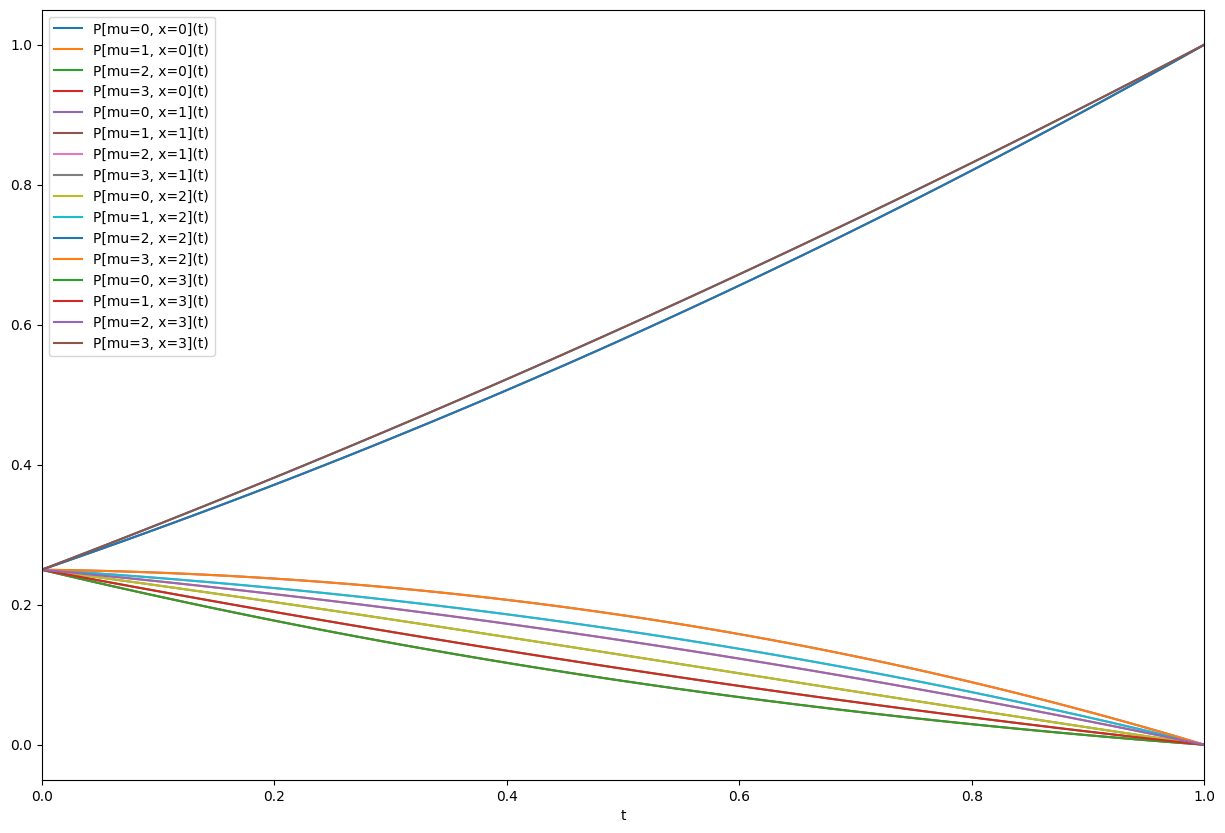

0.25 + 0.63541667·x + 0.11111111·x² + 0.00347222·x³
0.25 - 0.15625·x - 0.09027778·x² - 0.00347222·x³
0.25 - 0.3125·x + 0.05555556·x² + 0.00694444·x³
0.25 - 0.39583333·x + 0.16666667·x² - 0.02083333·x³
0.25 - 0.02083333·x - 0.20833333·x² - 0.02083333·x³
0.25 + 0.57291667·x + 0.16666667·x² + 0.01041667·x³
0.25 - 0.10416667·x - 0.13194444·x² - 0.01388889·x³
0.25 - 0.21875·x - 0.06944444·x² + 0.03819444·x³
0.25 - 0.21875·x - 0.06944444·x² + 0.03819444·x³
0.25 - 0.10416667·x - 0.13194444·x² - 0.01388889·x³
0.25 + 0.57291667·x + 0.16666667·x² + 0.01041667·x³
0.25 - 0.02083333·x - 0.20833333·x² - 0.02083333·x³
0.25 - 0.39583333·x + 0.16666667·x² - 0.02083333·x³
0.25 - 0.3125·x + 0.05555556·x² + 0.00694444·x³
0.25 - 0.15625·x - 0.09027778·x² - 0.00347222·x³
0.25 + 0.63541667·x + 0.11111111·x² + 0.00347222·x³


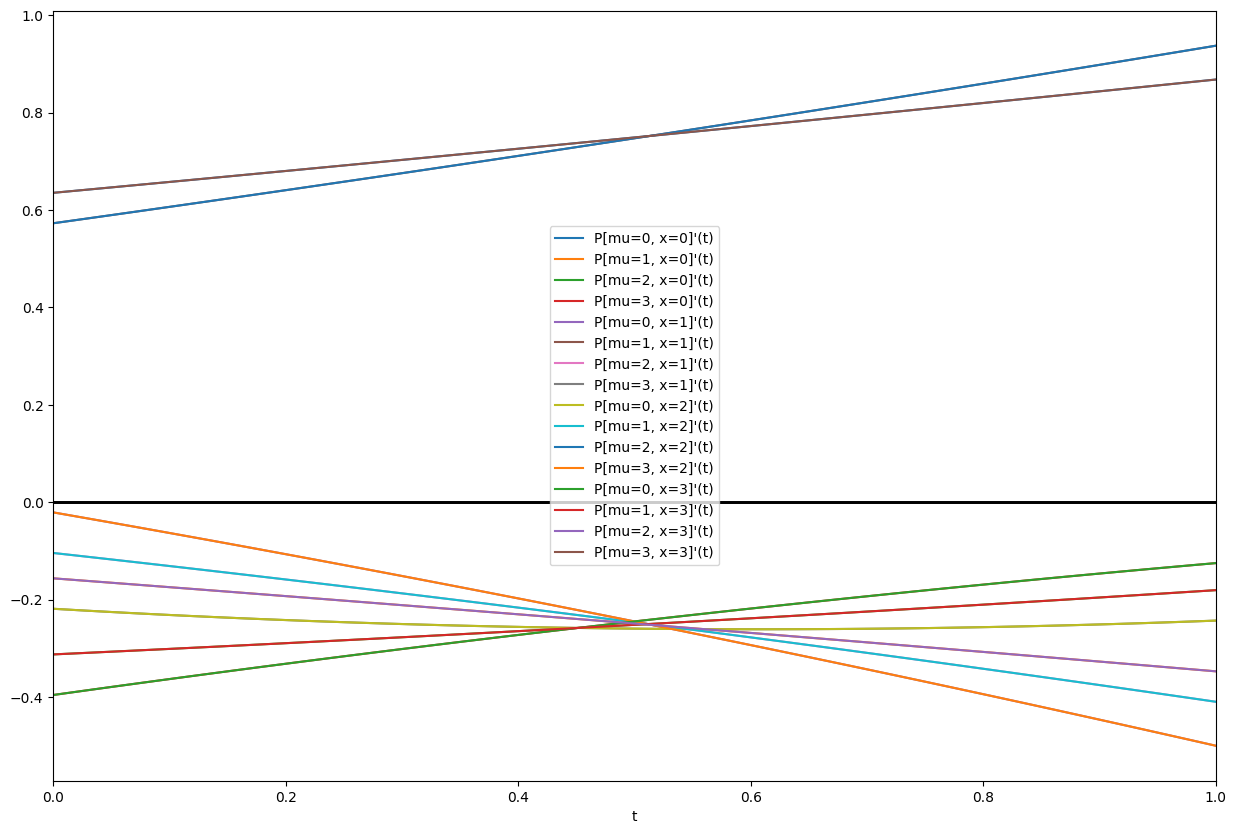

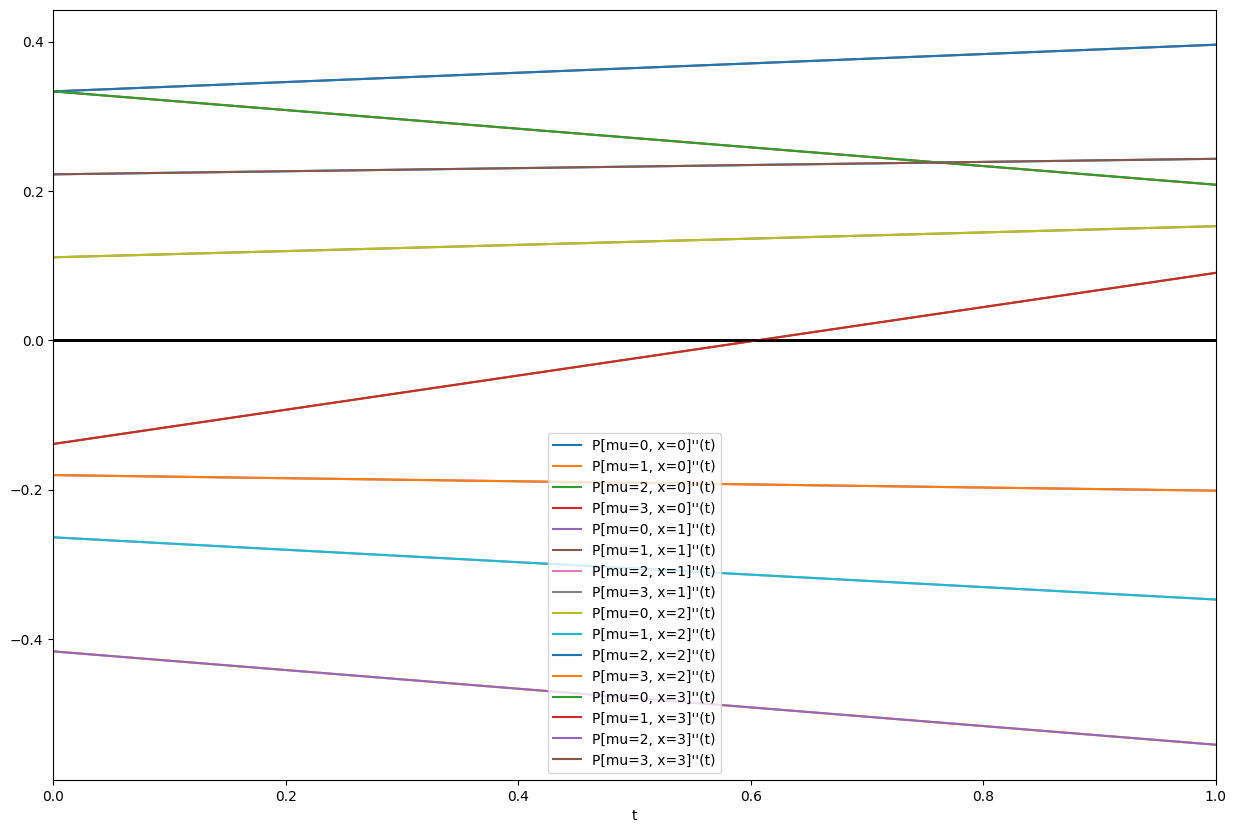

In [11]:
M = 4
u = compute_polynomials(M)
xs = np.linspace(0, 1, 100)

plt.figure(figsize=(15, 10))
for x in range(M):
    for mu in range(M):
        coeffs = u[mu, x][::-1]
        p = np.polynomial.Polynomial(coeffs)

        plt.plot(xs, p(xs), label=f"P[{mu=}, {x=}](t)")
        plt.xlabel('t')
        plt.xlim(0, 1)
plt.legend()
plt.show()

plt.figure(figsize=(15, 10))
for x in range(M):
    for mu in range(M):
        coeffs = u[mu, x][::-1]
        p = np.polynomial.Polynomial(coeffs)
        print(p)

        plt.plot(xs, p.deriv()(xs), label=f"P[{mu=}, {x=}]'(t)")
        plt.axhline(0, color='black', lw=1)
        plt.xlabel('t')
        plt.xlim(0, 1)
plt.legend()
plt.show()

plt.figure(figsize=(15, 10))
for x in range(M):
    for mu in range(M):
        coeffs = u[x, mu][::-1]
        p = np.polynomial.Polynomial(coeffs)
        plt.plot(xs, p.deriv(2)(xs), label=f"P[{mu=}, {x=}]''(t)")
        plt.axhline(0, color='black', lw=1)
        plt.xlabel('t')
        plt.xlim(0, 1)
plt.legend()


In [61]:
def check_bi_monocity(seq: np.ndarray) -> bool:
    """
    Check if the sequence is bi-monotonic ie the sequence is
    increasing and then decreasing (pssibly with an empty increasing or decreasing part).

    Parameters
    ----------
    seq : np.ndarray
        Sequence to check.
    
    Returns
    -------
    bool
        True if the sequence is bi-monotonic, False otherwise.
    """
    diff = np.diff(seq)
    sign = 0
    changed = False
    for d in diff:
        if sign * d < 0:
            if changed:
                return False
            changed = True
        sign = np.sign(d)
    return True
    

In [81]:
def check_unimodality(seq: np.ndarray) -> bool:
    """
    Check if the sequence is unimodal ie only negative values followed by some zeros and then only positive values
    (possibly with an empty positive or negative part).

    Parameters
    ----------
    seq : np.ndarray
        The sequence to check.
    
    Returns
    -------
    bool
        True if the sequence is unimodal, False otherwise.
    """
    seq = np.sign(seq)
    i = 0
    while i < len(seq) and seq[i] > 0:
        i += 1
    while i < len(seq) and seq[i] == 0:
        i += 1
    return np.all(seq[i:] < 0)

In [82]:
def check_bi_monocity2(seq: np.ndarray) -> bool:
    """
    Check if the sequence is bi-monotonic ie the sequence is
    increasing and then decreasing (pssibly with an empty increasing or decreasing part).

    Parameters
    ----------
    seq : np.ndarray
        Sequence to check.
    
    Returns
    -------
    bool
        True if the sequence is bi-monotonic, False otherwise.
    """
    return check_unimodality(np.diff(seq))    

In [64]:
god_coefs.keys()

dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26])

In [66]:
for M in tqdm(range(26, 0, -1)):
    u = god_coefs[M]

    eps = 1e-5
    xs = np.linspace(eps, 1 - eps, 10_000)
    for x in range(M):
        for mu in range(M):
            # f = lambda t: np.log(
            #     np.polynomial.Polynomial(u[x, mu])((1 - t)/t)) + np.log(t) * (M - 1)
            f = lambda t: np.polynomial.Polynomial(u[x, mu])((1 - t)/t) * t ** (M - 1)
            # plt.plot(xs, f(xs), label=f'log P({x}, {mu})')
            bi_monotonic = check_bi_monocity(f(xs))
            assert bi_monotonic, f'Failed for {M=} {x=}, mu={mu}'

  0%|          | 0/26 [00:00<?, ?it/s]

In [69]:
for M in tqdm(range(26, 0, -1)):
    u = god_coefs[M]

    eps = 1e-5
    xs = np.linspace(eps, 1 - eps, 10_000)
    for x in range(M):
        for mu in range(M):
            f = lambda t: np.log(
                np.polynomial.Polynomial(u[x, mu])((1 - t)/t)) + np.log(t) * (M - 1)
            # f = lambda t: np.polynomial.Polynomial(u[x, mu])((1 - t)/t) * t ** (M - 1)
            # plt.plot(xs, f(xs), label=f'log P({x}, {mu})')
            bi_monotonic = check_bi_monocity(f(xs))
            assert bi_monotonic, f'Failed for {M=} {x=}, mu={mu}'

  0%|          | 0/26 [00:00<?, ?it/s]

In [84]:
for M in tqdm(range(26, 0, -1)):
    u = god_coefs[M]

    eps = 1e-5
    xs = np.linspace(eps, 1 - eps, 100_000)
    for x in range(M):
        for mu in range(M):
            f = lambda t: np.log(
                np.polynomial.Polynomial(u[x, mu])((1 - t)/t)) + np.log(t) * (M - 1)
            # f = lambda t: np.polynomial.Polynomial(u[x, mu])((1 - t)/t) * t ** (M - 1)
            # plt.plot(xs, f(xs), label=f'log P({x}, {mu})')
            bi_monotonic = check_bi_monocity2(f(xs))
            assert bi_monotonic, f'Failed for {M=} {x=}, mu={mu}'

  0%|          | 0/26 [00:00<?, ?it/s]

In [78]:
values = f(xs)
values.shape

(100000,)

In [79]:
delta = np.diff(values)
delta.shape

(99999,)

In [66]:
M = 24
u = compute_polynomials_god(M)

    

KeyboardInterrupt: 

In [ ]:
eps = 1e-5
xs = np.linspace(eps, 1 - eps, 100)
for x in range(M):
    for mu in range(M):
        f = lambda t: np.log(
            np.polynomial.Polynomial(u[x, mu])((1 - t)/t) * t ** (M - 1)
            )
        # plt.plot(xs, f(xs), label=f'log P({x}, {mu})')
        bi_monotonic = check_bi_monocity(f(xs))
        assert bi_monotonic, f'Failed for {M=} {x=}, mu={mu}'

Failed for M=10 i=0, mu=4 u=array([0.  , 0.84, 0.08, 0.2 , 0.37, 0.33, 0.43, 0.94, 0.14, 0.56])
Failed for M=10 i=6, mu=4 u=array([0.  , 0.8 , 0.32, 0.45, 0.44, 0.37, 0.5 , 0.91, 0.97, 0.4 ])
Failed for M=10 i=8, mu=4 u=array([0.  , 0.13, 0.73, 0.63, 0.76, 0.74, 0.45, 0.26, 0.33, 0.56])


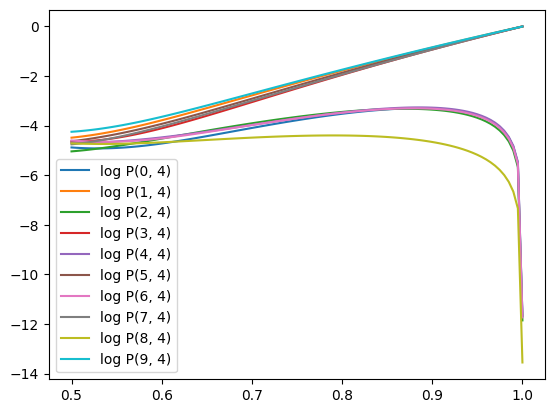

In [59]:
M = 10
# u = compute_polynomials_god(5)

eps = 1e-5
xs = np.linspace(eps + 1/2, 1 - eps, 100)
for i in range(10):
    u = np.random.randint(1, 100, size=M) / 100
    u[0] = i % 2
    f = lambda t: np.log(
        np.polynomial.Polynomial(u)((1 - t)/t) * t ** (M - 1)
        )
    plt.plot(xs, f(xs), label=f'log P({i}, {mu})')
    bi_monotonic = check_bi_monocity(f(xs))
    if not bi_monotonic:
        print(f'Failed for {M=} {i=}, mu={mu} {u=}')
plt.legend()

Failed for M=10, mu=4 u=array([0.  , 0.84, 0.08, 0.2 , 0.37, 0.33, 0.43, 0.94, 0.14, 0.56])


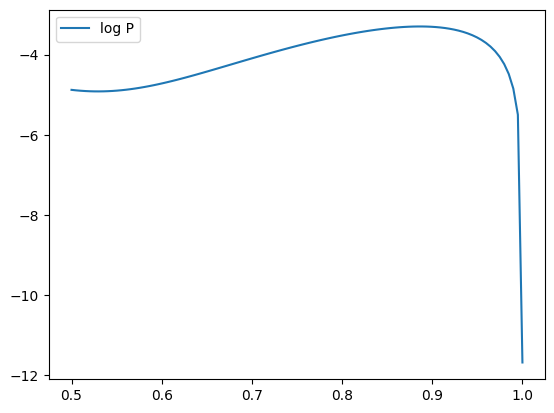

In [61]:
M = 10
# u = compute_polynomials_god(5)

eps = 1e-5
xs = np.linspace(eps + 1/2, 1 - eps, 100)

u=np.array([0.  , 0.84, 0.08, 0.2 , 0.37, 0.33, 0.43, 0.94, 0.14, 0.56])
f = lambda t: np.log(
    np.polynomial.Polynomial(u)((1 - t)/t) * t ** (M - 1)
    )
plt.plot(xs, f(xs), label=f'log P')
bi_monotonic = check_bi_monocity(f(xs))

if not bi_monotonic:
    print(f'Failed for {M=}, mu={mu} {u=}')
plt.legend()

In [40]:
M = 5
u = compute_polynomials_god(5)
u[:, :, 0]

array([[1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.]])

In [46]:
lp(x)

array([-4.51003086e-05, -7.55996929e-05, -1.18936068e-04, -1.78027476e-04,
       -2.56126286e-04, -3.56829062e-04, -4.84086559e-04, -6.42213837e-04,
       -8.35900501e-04, -1.07022106e-03, -1.35064539e-03, -1.68304940e-03,
       -2.07372567e-03, -2.52939438e-03, -3.05721422e-03, -3.66479355e-03,
       -4.36020155e-03, -5.15197960e-03, -6.04915273e-03, -7.06124120e-03,
       -8.19827222e-03, -9.47079176e-03, -1.08898765e-02, -1.24671460e-02,
       -1.42147746e-02, -1.61455041e-02, -1.82726562e-02, -2.06101445e-02,
       -2.31724880e-02, -2.59748233e-02, -2.90329176e-02, -3.23631822e-02,
       -3.59826852e-02, -3.99091650e-02, -4.41610434e-02, -4.87574398e-02,
       -5.37181844e-02, -5.90638318e-02, -6.48156755e-02, -7.09957614e-02,
       -7.76269022e-02, -8.47326917e-02, -9.23375191e-02, -1.00466583e-01,
       -1.09145909e-01, -1.18402358e-01, -1.28263648e-01, -1.38758365e-01,
       -1.49915982e-01, -1.61766868e-01, -1.74342309e-01, -1.87674521e-01,
       -2.01796666e-01, -

In [1]:
import sympy as sp

In [3]:
x = sp.symbols('x', real=True, positive=True)
d = sp.symbols('d', integer=True, positive=True)
i = sp.symbols('i', integer=True, positive=True)
j = sp.symbols('j', integer=True, positive=True)

cd = ((1 - x)  / x ) ** d
cd_ = sp.simplify(sp.diff(cd, x))
my_cd_ = -d * x ** (-2) * ((1 - x)  / x ) ** (d - 1)
cd__ = sp.simplify(sp.diff(cd, x, 2))
my_cd__ = d  * x ** (-4) * (1 - 2 * x + d) * ((1 - x)  / x ) ** (d - 2)

dlogcd = sp.simplify(sp.diff(sp.log(cd), x, 2))
my_dlogcd = -d * x ** (-4) * (2* x - 1) * ((1 - x)  / x ) ** (2 *  d - 2) / (  ((1 - x)  / x ) ** (2 *  d ) )

cd

((1 - x)/x)**d

In [27]:
x = sp.symbols('x', real=True, positive=True)
d = sp.symbols('d', integer=True, positive=True)
m = sp.symbols('m', integer=True, positive=True)

cd = (1 - x) ** d * x ** (m - 1 - d)
cd_ = sp.simplify(sp.diff(cd, x))
my_cd_ = ((1 - m) * x + m - 1 - d) * (1 - x) ** (d - 1) * x ** (m - 2 - d)

cd

x**(-d + m - 1)*(1 - x)**d

In [29]:
sp.simplify(cd_ - my_cd_)

x**(-d + m - 2)*((-1)**d*(x - 1)**(d - 1)*(d + m*x - m - x + 1) + (1 - x)**(d - 1)*(d - m + x*(m - 1) + 1))

In [89]:
cd_

(-1)**d*d*x**(-d - 1)*(x - 1)**(d - 1)

In [90]:
cd__

(-1)**(d + 1)*d*x**(-d - 2)*(x - 1)**(d - 2)*(-d + 2*x - 1)

In [91]:
sp.simplify(cd_ - sp.simplify(my_cd_))


d*x**(-d - 1)*((-1)**d*(x - 1)**(d - 1) + (1 - x)**(d - 1))

In [92]:
cd__

(-1)**(d + 1)*d*x**(-d - 2)*(x - 1)**(d - 2)*(-d + 2*x - 1)

In [93]:
sp.simplify(cd__ - sp.simplify(my_cd__))

d*x**(-d - 2)*((-1)**d*(x - 1)**(d - 2) - (1 - x)**(d - 2))*(d - 2*x + 1)

In [94]:
dlogcd

-d*(2*x - 1)/(x**2*(x - 1)**2)

In [97]:
sp.simplify(dlogcd - sp.simplify(my_dlogcd))

0

In [62]:
# derivative of cd

for d in range(100):

    cd = ((1 - x)  / x ) ** d

    cd_ = sp.diff(cd, x)
    my_cd_ = -d * x ** (-2) * ((1 - x)  / x ) ** (d - 1)

    assert sp.simplify(cd_ - my_cd_ ) == 0, f'Failed for {d=} {cd_=} {my_cd_=}'

    cd__ = sp.diff(cd, x, 2)
    my_cd__ = d * x ** (-4) * (1 - 2 * x + d) * ((1 - x)  / x ) ** (d - 2)

    assert sp.simplify(cd__ - my_cd__ ) == 0, f'Failed for {d=} {cd__=} {my_cd__=}'

In [39]:
sp.diff(cd, x, 2)

d*(-(x - 1)/x)**d*(1 - (x - 1)/x)*(d*(1 - (x - 1)/x)/(x - 1) - 1/(x - 1) - 1/x)/(x - 1)

In [ ]:
x = sp.symbols('x', real=True, positive=True)
d = sp.symbols('d', integer=True, positive=True)
i = sp.symbols('i', integer=True, positive=True)
j = sp.symbols('j', integer=True, positive=True)

cd = ((1 - x)  / x ) ** d
cd_ = sp.simplify(sp.diff(cd, x))
my_cd_ = -d * x ** (-2) * ((1 - x)  / x ) ** (d - 1)
cd__ = sp.simplify(sp.diff(cd, x, 2))
my_cd__ = d  * x ** (-4) * (1 - 2 * x + d) * ((1 - x)  / x ) ** (d - 2)

dlogcd = sp.simplify(sp.diff(sp.log(cd), x, 2))
my_dlogcd = -d * x ** (-4) * (2* x - 1) * ((1 - x)  / x ) ** (2 *  d - 2) / (  ((1 - x)  / x ) ** (2 *  d ) )

cd

((1 - x)/x)**d

In [115]:
i = 8
j = 7

ci = ((1 - x)  / x ) ** i
cj = ((1 - x)  / x ) ** j
ci_ = sp.simplify(sp.diff(ci, x))
cj_ = sp.simplify(sp.diff(cj, x))
ci__ = sp.simplify(sp.diff(ci, x, 2))
cj__ = sp.simplify(sp.diff(cj, x, 2))

In [116]:
cross = sp.simplify(2 * ci_ * cj_ - ci * cj__ - ci__ * cj)
cross

(x - 1)**13*(98*x**2 - 226*x*(x - 1) + 128*(x - 1)**2 - 112)/x**17

In [117]:
my_cross = x ** (-4) * ((1 - x)  / x ) ** (i + j - 2) * (-(j - i) ** 2 - (i + j) * (1 - 2 * x))
my_cross

(1 - x)**13*(30*x - 16)/x**17

In [118]:
sp.simplify(cross - my_cross)

0

In [119]:
for i in range(50):
    for j in range(50):

        ci = ((1 - x)  / x ) ** i
        cj = ((1 - x)  / x ) ** j
        ci_ = sp.simplify(sp.diff(ci, x))
        cj_ = sp.simplify(sp.diff(cj, x))
        ci__ = sp.simplify(sp.diff(ci, x, 2))
        cj__ = sp.simplify(sp.diff(cj, x, 2))

        cross = sp.simplify(2 * ci_ * cj_ - ci * cj__ - ci__ * cj)
        my_cross = x ** (-4) * ((1 - x)  / x ) ** (i + j - 2) * (-(j - i) ** 2 - (i + j) * (1 - 2 * x))

        assert sp.simplify(cross - my_cross) == 0, f'Failed for {i=} {j=} {cross=} {my_cross=}'

KeyboardInterrupt: 

In [15]:
x = sp.symbols('x', real=True, positive=True)
u = sp.symbols('u:7', real=True, sequence=True, positive=True)

c0 = 1
c1 = (1 - x) / x
c2 = ((1 - x) / x) ** 2
c3 = ((1 - x) / x) ** 3
c4 = ((1 - x) / x) ** 4
c5 = ((1 - x) / x) ** 5
c6 = ((1 - x) / x) ** 6

s = u[0] * c0 + u[1] * c1 + u[2] * c2 + u[3] * c3 + u[4] * c4 + u[5] * c5 + u[6] * c6

s = u[0] * c0 + u[1] * c1
s

u0 + u1*(1 - x)/x

In [16]:
dlog = sp.simplify(sp.diff(sp.log(s), x, 2))
dlog

-u1*(-2*u0*x + 2*u1*(x - 1) + u1)/(x**2*(u0*x - u1*(x - 1))**2)

In [17]:
s_ = sp.simplify(sp.diff(s, x))
s__ = sp.simplify(sp.diff(s, x, 2))
dlog_ = sp.simplify(s_ ** 2 - s * s__)
dlog_ * x **  4

u1*(-2*u0*x + 2*u1*x - u1)